# Testing out the variance subtraction method

In [1]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest
from astropy.table import vstack

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

master_hvcs = hvcl.load_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete


In [2]:
def get_stacked_sets(snapshots):
    inners = []
    outers = []
    for hvc_snap in snapshots:
        inner_rms, outer_rms = KStest.split_RMs(hvc_snap["RMs"],hvc_snap["HVC"]["SkyCoord"], KStest.morph_ring(hvc_snap))
        inners.append(inner_rms)
        outers.append(outer_rms)

    master_rm_inner = vstack(inners)
    master_rm_outer = vstack(outers)

    return master_rm_inner, master_rm_outer, inners, outers

master_rm_inner, master_rm_outer, inners, outers = get_stacked_sets(master_hvcs)

[]

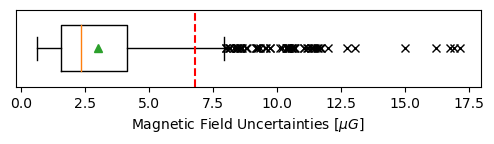

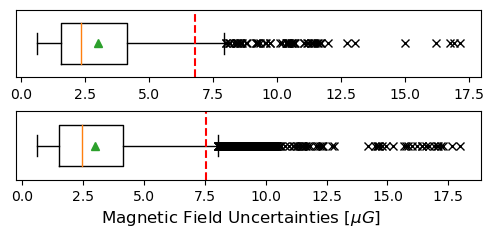

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def uncertainty_boxplot(master_rm, single=False, limit=20):
    rms = master_rm["B_virtual_unc [int]"].data * 1e6
    B_unc = rms[rms < 20]
    B_true_unc = np.std(master_rm["B_virtual [int]"].data * 1e6)

    if single:
        plt.figure(figsize=(6,1))
        plt.boxplot(B_unc, vert=False, showmeans=True, widths=0.6, sym="x")
        plt.axvline(B_true_unc, c='r', linestyle='--')
        plt.yticks([])
        plt.xlabel(r"Magnetic Field Uncertainties [$\mu G$]")
    else:
        plt.boxplot(B_unc, vert=False, showmeans=True, widths=0.6, sym="x")
        plt.axvline(B_true_unc, c='r', linestyle='--')
        plt.yticks([])

def uncertainty_boxplots(master_rm_inner, master_rm_outer):
    fig = plt.figure(figsize=(6,2.5))
    
    fig.supxlabel(r"Magnetic Field Uncertainties [$\mu G$]")

    plt.tight_layout()

    plt.subplot(2, 1, 1)
    uncertainty_boxplot(master_rm_inner)
    plt.subplot(2, 1, 2)
    uncertainty_boxplot(master_rm_outer)
    plt.subplots_adjust(hspace=0.5, bottom=0.2)

uncertainty_boxplot(master_rm_inner, True)
plt.plot()
uncertainty_boxplots(master_rm_inner, master_rm_outer)
plt.plot()

In [4]:
from astropy.table import Table, hstack, Column
import copy

def uncertainty_table(table_list):
    uncert = []
    for rms in table_list:
        m_list = rms["B_virtual_unc [int]"].data * 1e6
        o_list = rms["B_virtual [int]"].data * 1e6

        meas = np.mean(m_list)
        obsv = np.std(o_list)

        uncert.append({"Sigma [meas]":meas, "Sigma [obsv]":obsv, "Sigma [true]": np.sqrt(obsv**2 - meas**2)})

    uncert_table = Table(uncert)

    return uncert_table

def uncertainty_subtract(inners, outers):
    inner_sigma = uncertainty_table(inners)
    outer_sigma = uncertainty_table(outers)

    sub = inner_sigma["Sigma [true]"]-outer_sigma["Sigma [true]"]
    fwhm = 2 * np.sqrt(2 * np.log(2)) * np.array(sub)

    fwhm_table = copy.deepcopy(inner_sigma)

    fwhm_table.add_column(sub, name="Sigma [diff]")
    fwhm_table.add_column(fwhm, name="FWHM")

    return fwhm_table, inner_sigma, outer_sigma

fwhm_table, inner_sigma, outer_sigma = uncertainty_subtract(inners, outers)

fwhm_table

C:\Users\olive\AppData\Local\Temp\ipykernel_16016\1208703601.py:13: RuntimeWarning: invalid value encountered in sqrt
  uncert.append({"Sigma [meas]":meas, "Sigma [obsv]":obsv, "Sigma [true]": np.sqrt(obsv**2 - meas**2)})


Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM
float64,float64,float64,float64,float64
1.5490103064419392,3.259633374868092,2.8680615072014404,-1.2004037875138898,-2.82673490096878
1.0172162310775188,2.2736826533710723,2.033446322742001,-0.3820916381721009,-0.8997570486063758
1.3692498776485982,3.4139391636197307,3.1273207998949974,-0.3219533860094135,-0.7581422869405536
1.7766805216998156,6.285240753776755,6.028901861595415,4.354124583319416,10.253179847362592
1.390653120203451,0.6443423969361269,nan,nan,nan
2.5577313774843344,3.3456971641453612,2.1567799412092095,-0.4370240961740395,-1.0291131018321615
8.363070544185819,12.507923833010205,9.300925205879048,5.8850039182248,13.858125191721438
5.0791565705667105,9.744382180123484,8.315957708164293,-11.277167064796421,-26.555699055345446
3.023390368905306,4.983729795251348,3.9619027435421326,0.16014564072012671,0.377114164892079


In [14]:
def uncertainty_readwrite(uncert_table, filter_significant=False, load_file="../data_processed/hvc_KS_tests/hvc_KS_average", save_file="../data_processed/results_pre"):
    ks = ct.read_processed(load_file)
    hks = hstack([ks, uncert_table])

    if filter_significant:
        hks = hks[hks["Significant"]]
        hks = hks[~np.isnan(hks["Sigma [diff]"])]

    ct.write_processed(hks, save_file)

    return hks

results = uncertainty_readwrite(fwhm_table)
results_filtered = uncertainty_readwrite(fwhm_table, save_file="../data_processed/results_filtered", filter_significant=True)

In [15]:
results_filtered

Name,Statistic,p_value,Statistic_x,Statistic_sgn,Statistic_diff,Significant,Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM
str15,float64,float64,float64,int32,float64,bool,float64,float64,float64,float64,float64
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,2.5503785393572116,True,1.5490103064419392,3.259633374868092,2.8680615072014404,-1.2004037875138898,-2.82673490096878
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,1.245611675868496,True,1.0172162310775188,2.2736826533710723,2.033446322742001,-0.3820916381721009,-0.8997570486063758
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,2.2846397376409495,True,1.3692498776485982,3.4139391636197307,3.1273207998949974,-0.3219533860094135,-0.7581422869405536
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,7.064597943499491,True,8.363070544185819,12.507923833010205,9.300925205879048,5.8850039182248,13.858125191721438
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,5.008552948039634,True,5.0791565705667105,9.744382180123484,8.315957708164293,-11.277167064796421,-26.555699055345446
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,-2.1167595348071426,True,3.023390368905306,4.983729795251348,3.9619027435421326,0.16014564072012671,0.377114164892079
G267.1-38.4+263,0.3428488020518381,2.318648482161409e-11,12.715164074377505,-1,9.411860771074203,True,6.459354538810761,13.975229335809928,12.392892072895142,3.764226145036,8.86407518036035
G271.6-48.4+297,0.12493061782161308,5.0905622111774864e-05,0.6348560731135152,-1,0.5747960130534552,True,1.656313599761247,3.0167700520864895,2.5214136523807156,0.14031802939919347,0.33042370830846285
G271.7-53.1+254,0.22697520500279825,0.0003403465863955054,0.11625707523884121,1,-2.3862454272636606,True,3.238101358605643,6.206104031068475,5.294376907232867,-0.6047436349837891,-1.4240624337647063


In [16]:
results

Name,Statistic,p_value,Statistic_x,Statistic_sgn,Statistic_diff,Significant,Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM
str15,float64,float64,float64,int32,float64,bool,float64,float64,float64,float64,float64
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,2.5503785393572116,True,1.5490103064419392,3.259633374868092,2.8680615072014404,-1.2004037875138898,-2.82673490096878
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,1.245611675868496,True,1.0172162310775188,2.2736826533710723,2.033446322742001,-0.3820916381721009,-0.8997570486063758
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,2.2846397376409495,True,1.3692498776485982,3.4139391636197307,3.1273207998949974,-0.3219533860094135,-0.7581422869405536
G089.0-64.7-311,0.3738140417457306,0.015075834341180974,-3.5031459148744912,1,-2.4420848538134305,False,1.7766805216998156,6.285240753776755,6.028901861595415,4.354124583319416,10.253179847362592
G133.5-75.6-294,0.46130268199233715,4.570648166268751e-08,-1.0081759072724916,-1,1.7746068755102902,True,1.390653120203451,0.6443423969361269,nan,nan,nan
G248.9+36.8+181,0.08070447918650822,0.452664079053446,-2.5040967925547646,-1,0.5189262304682574,False,2.5577313774843344,3.3456971641453612,2.1567799412092095,-0.4370240961740395,-1.0291131018321615
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,7.064597943499491,True,8.363070544185819,12.507923833010205,9.300925205879048,5.8850039182248,13.858125191721438
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,5.008552948039634,True,5.0791565705667105,9.744382180123484,8.315957708164293,-11.277167064796421,-26.555699055345446
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,-2.1167595348071426,True,3.023390368905306,4.983729795251348,3.9619027435421326,0.16014564072012671,0.377114164892079


# Putting it all together

In [1]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest, uncertainty_subtraction as us

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs_filtered"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

#master_hvcs = hvcl.manual_filter_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])

#results = hvcl.uncertainty_subtract_HVCs(collated_data, filter_significant=False, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])#, save_file="", filter_significant=False)

results = ct.read_processed("../data_processed/results_pre")
results_filtered = us.filter_significant(results)

#collated_data['HVCs']
results

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete


Name,Statistic,p_value,Statistic_x,Statistic_sgn,Statistic_diff,Significant,Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM
str15,float64,float64,float64,int32,float64,bool,float64,float64,float64,float64,float64
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,2.5503785393572116,True,1.5490103064419392,3.259633374868092,2.8680615072014404,-1.2004037875138898,-2.82673490096878
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,1.245611675868496,True,1.0172162310775188,2.2736826533710723,2.033446322742001,-0.3820916381721009,-0.8997570486063758
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,2.2846397376409495,True,1.3692498776485982,3.4139391636197307,3.1273207998949974,-0.3219533860094135,-0.7581422869405536
G089.0-64.7-311,0.3738140417457306,0.015075834341180974,-3.5031459148744912,1,-2.4420848538134305,False,1.7766805216998156,6.285240753776755,6.028901861595415,4.354124583319416,10.253179847362592
G133.5-75.6-294,0.46130268199233715,4.570648166268751e-08,-1.0081759072724916,-1,1.7746068755102902,True,1.390653120203451,0.6443423969361269,nan,nan,nan
G248.9+36.8+181,0.08070447918650822,0.452664079053446,-2.5040967925547646,-1,0.5189262304682574,False,2.5577313774843344,3.3456971641453612,2.1567799412092095,-0.4370240961740395,-1.0291131018321615
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,7.064597943499491,True,8.363070544185819,12.507923833010205,9.300925205879048,5.8850039182248,13.858125191721438
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,5.008552948039634,True,5.0791565705667105,9.744382180123484,8.315957708164293,-11.277167064796421,-26.555699055345446
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,-2.1167595348071426,True,3.023390368905306,4.983729795251348,3.9619027435421326,0.16014564072012671,0.377114164892079


In [2]:
collated_data['HVCs']

Name,SkyCoord,RAJ2000,DEJ2000,VLSR,e_VLSR,VGSR,Vdev,FWHM,TbFit,NH,e_NH,Area,dx,dy,Flag,HI,WW91,Simbad,recno,Cat,Nearest RM
,"deg,deg",,,km / s,km / s,km / s,km / s,km / s,K,1 / cm2,1 / cm2,deg2,deg,deg,,,,,,,deg
str15,SkyCoord,str11,str9,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str4,str19,str18,str6,int32,str4,float64
G038.7-37.3-241,"318.95132749810114,-11.83861664753068",21 15 48.32,-11 50 19,-241.4,1.0,-131.9,-203.9,12.2,0.87,3e+19,1e+18,1.5,4.2,3.0,"T,H6",HVC 038.9-37.1-230,"GCN_GCN,EN,MS_MS",Simbad,329,GHVC,0.18999947004444442
G038.8-33.2-261,"315.26399401780566,-10.006394575192065",21 01 03.36,-10 00 23,-261.0,1.0,-145.6,-223.5,20.7,0.94,4e+19,2e+18,2.2,4.9,3.9,"T,H8",HVC 039.0-33.4-256,"GCN_GCN,EN,MS_MS",Simbad,330,GHVC,0.11689431635833333
G043.4-30.4-230,"314.53824383026614,-5.268616824159749",20 58 09.18,-05 16 07,-230.7,1.0,-100.4,-193.2,22.9,0.64,3e+19,2e+18,1.6,3.4,3.0,H1,HVC 043.1-30.0-218,"GCN_GCN,EN,N,MS_MS",Simbad,354,GHVC,0.1480177971361111
G089.0-64.7-311,"359.0471191770445,-5.603613730466462",23 56 11.31,-05 36 13,-311.7,1.0,-217.9,-274.2,18.9,0.50,2e+19,2e+18,1.4,3.4,3.1,H3,HVC 089.4-64.7-314,"EN,MS_MS",Simbad,408,GHVC,0.10718682865555557
G133.5-75.6-294,"15.548161692114391,-13.005834286896315",01 02 11.56,-13 00 21,-294.1,1.8,-254.6,-261.6,26.8,0.42,2e+19,3e+18,1.3,4.2,1.4,H2,HVC 131.9-75.8-302,"EN,MS_MS",Simbad,427,GHVC,0.048293947366666666
G248.9+36.8+181,"152.03907642863186,-8.363884064380029",10 08 09.38,-08 21 50,181.6,4.6,17.3,139.1,22.4,0.13,1e+19,2e+18,1.1,2.1,1.6,--,--,"WA,P,EP",Simbad,588,GHVC,0.17119747194444443
G261.5-34.5+237,"80.51641498466985,-53.96443940870481",05 22 03.94,-53 57 52,237.0,2.7,57.8,194.5,26.6,0.28,6e+18,3e+18,1.5,2.6,2.0,H1,HVC 261.5-34.6+237,"P,MS_MS,EP",Simbad,722,GHVC,0.11800674041944445
G262.4-26.2+143,"94.79587147051343,-54.00693872468238",06 19 11.01,-54 00 25,143.6,1.9,-52.0,101.1,19.5,0.28,1e+19,2e+18,1.6,3.1,2.6,H1,HVC 261.8-26.0+148,"P,MS_MS",Simbad,729,GHVC,0.06030011547777778


## The final boxplot

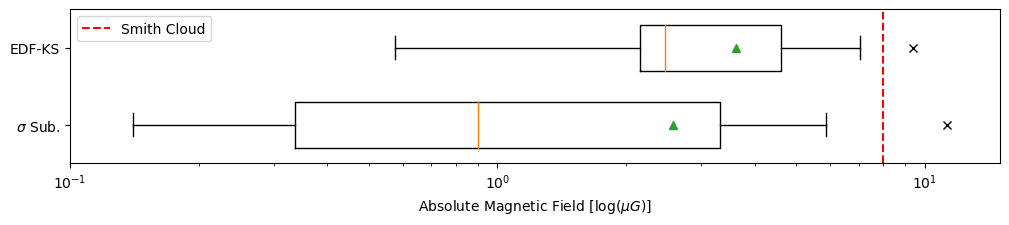

In [43]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(6,1))
#plt.boxplot(abs(results["Statistic_diff"]), vert=False, showmeans=True, widths=0.6, sym="x")
#plt.yticks([])
#plt.axvline(8, c='r', linestyle='--')
#plt.xlabel(r"Magnetic Field [log($\mu G$)]")
#plt.xscale('log')
#plt.show()

#plt.figure(figsize=(6,1))
#plt.boxplot(abs(results["Sigma [diff]"]), vert=False, showmeans=True, widths=0.6, sym="x")
#plt.yticks([])
#plt.axvline(8, c='r', linestyle='--')
#plt.xlabel(r"Magnetic Field [log($\mu G$)]")
#plt.xscale('log')
#plt.show()

dic = {r"$\sigma$ Sub.": abs(results_filtered["Sigma [diff]"]), "EDF-KS": abs(results_filtered["Statistic_diff"])}
plt.figure(figsize=(12,2))
plt.boxplot(dic.values(), labels=dic.keys(), vert=False, showmeans=True, widths=0.6, sym="x")
plt.axvline(8, c='r', linestyle='--', label=r"Smith Cloud")
plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.xscale('log')
plt.xlim(0.1, 15)
#plt.legend(bbox_to_anchor=(0.25, -0.3))
#plt.legend(bbox_to_anchor=(0.3, 1.2))
plt.legend()
plt.show()

## Is there a relationship with velocity?

Var. Sub. Grad.: -7.20010809381582
KS-EDF Grad.:    -8.226216170135094
Var. Sub. R^2: 0.46949048119430953
KS-EDF R^2:    0.36480703193040326


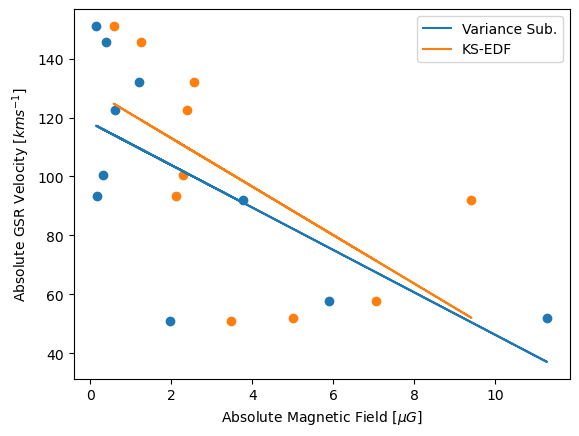

In [52]:
from astropy.table import hstack
from scipy.stats import linregress
import numpy as np

results_stack = us.filter_significant(hstack([results, collated_data['HVCs']]))

plt.scatter(abs(results_stack["Sigma [diff]"]), abs(results_stack['VGSR']))
plt.scatter(abs(results_stack["Statistic_diff"]), abs(results_stack['VGSR']))

pf10, pf11, r_value1, p_value1, std_err1 = linregress(abs(results_stack["Sigma [diff]"]), abs(results_stack['VGSR']))
pf20, pf21, r_value2, p_value2, std_err2 = linregress(abs(results_stack["Statistic_diff"]), abs(results_stack['VGSR']))

plt.plot(abs(results_stack["Sigma [diff]"]), pf10 * abs(results_stack["Sigma [diff]"]) + pf11, label="Variance Sub.")
plt.plot(abs(results_stack["Statistic_diff"]), pf20 * abs(results_stack["Statistic_diff"]) + pf21, label="KS-EDF")

plt.xlabel(r"Absolute Magnetic Field [$\mu G$]")
plt.ylabel(r"Absolute GSR Velocity [$km s^{-1}$]")
plt.legend()

print(r"Var. Sub. Grad.: "+str(pf10))
print(r"KS-EDF Grad.:    "+str(pf20))

print(r"Var. Sub. R^2: "+str(r_value1**2))
print(r"KS-EDF R^2:    "+str(r_value2**2))

plt.show()

Var. Sub. slope: -17.805664205141778
KS-EDF slope:    -34.84456795228249
Var. Sub. x-int: 2.230997544596407
KS-EDF x-int:    2.15066290491125
Var. Sub. R^2:   0.5186636363538069
KS-EDF R^2:      0.5714890256256061


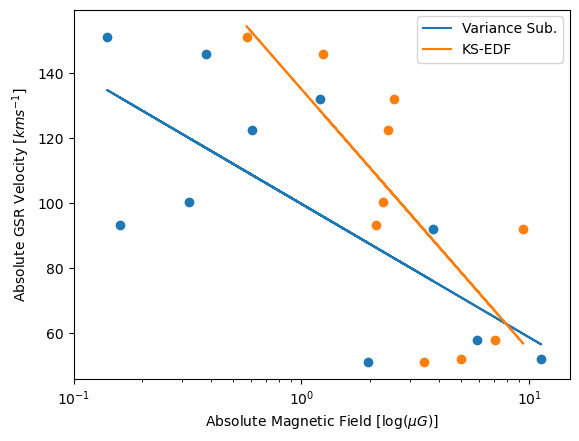

In [56]:
plt.scatter(abs(results_stack["Sigma [diff]"]), abs(results_stack['VGSR']))
plt.scatter(abs(results_stack["Statistic_diff"]), abs(results_stack['VGSR']))

plt.xscale('log')
plt.xlim(0.1, 15)

pf10, pf11, r_value1, p_value1, std_err1 = linregress(np.log(abs(results_stack["Sigma [diff]"])), abs(results_stack['VGSR']))
pf20, pf21, r_value2, p_value2, std_err2 = linregress(np.log(abs(results_stack["Statistic_diff"])), abs(results_stack['VGSR']))

plt.plot(abs(results_stack["Sigma [diff]"]), pf10 * np.log(abs(results_stack["Sigma [diff]"])) + pf11, label="Variance Sub.")
plt.plot(abs(results_stack["Statistic_diff"]), pf20 * np.log(abs(results_stack["Statistic_diff"])) + pf21, label="KS-EDF")

plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.ylabel(r"Absolute GSR Velocity [$km s^{-1}$]")
plt.legend()

print(r"Var. Sub. slope: "+str(pf10))
print(r"KS-EDF slope:    "+str(pf20))

#print(r"Var. Sub. y-int: "+str(pf11))
#print(r"KS-EDF y-int:    "+str(pf21))

print(r"Var. Sub. x-int: "+str((60-pf11)/pf10))
print(r"KS-EDF x-int:    "+str((60-pf21)/pf20))

print(r"Var. Sub. R^2:   "+str(r_value1**2))
print(r"KS-EDF R^2:      "+str(r_value2**2))

plt.show()

Inverse relationship points to these HVCs being more affected by drag from magnetic field pressure than ram pressure.

## Residuals between two methods

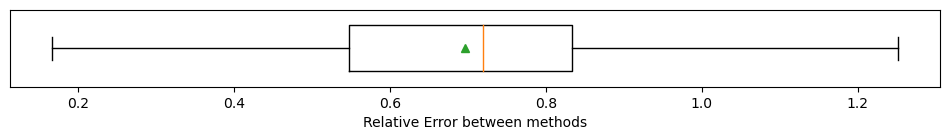

In [58]:
plt.figure(figsize=(12,1))
plt.boxplot(abs(abs(results_filtered["Sigma [diff]"])-abs(results_filtered["Statistic_diff"]))/abs(results_filtered["Statistic_diff"]), vert=False, showmeans=True,widths=0.6, sym="x")
plt.yticks([])
#plt.axvline(8, c='r', linestyle='--', label=r"Smith Cloud")
plt.xlabel(r"Relative Error between methods")
#plt.xscale('log')
#plt.xlim(0.1, 15)
#plt.legend()
plt.show()